In [1]:
%matplotlib inline

import os, sys
import numpy as np
import datetime as dt
import xesmf as xe
from dateutil.relativedelta import relativedelta

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

sys.path.append("../pycommon")
from pps_tools import set_cartopy_gridlines, set_cartopy_colorbar

from regrid_tools import iterative_fill_POP_core
 

In [2]:
%ls nudging_utils

OISSS_L4_multimission_global_monthly_v1.0_2014-01.nc
OISSS_L4_multimission_global_monthly_v1.0_2014-01.nc.html
OISSS_L4_multimission_global_monthly_v1.0_2021-02.nc
SMAP_L2B_SSS_36950_20220101T005200_R18240_V5.0.h5
SMAP_L3_SSS_20220105_8DAYS_V5.0.nc
WOA05_pottemp_salt.nc
flood_salt_restore_PHC2.1440x1080.v20180405.nc
iced_ocean_topog2.nc
ocean_static.nc
ocean_topog.nc
woa18/
woa18_decav_s01_04.nc
woa18_decav_s02_04.nc


In [3]:
# file name of the regrid info
fn_regridder = "regridInfo_bilinear_720x1440_tripolar_1080x1440_peri.nc"


# read in the lat & lon of the output tripolar grid 
fn_grd_out = 'nudging_utils/flood_salt_restore_PHC2.1440x1080.v20180405.nc'
f = Dataset(fn_grd_out)
lat2d_grd_out = f.variables['lat'][:]
lon2d_grd_out = f.variables['lon'][:]
sss_grd_out   = f.variables['SALT'][:]
f.close()


# read in the land/ocean mask of the output tripolar grid
fn_mask = 'nudging_utils/ocean_topog.nc'
f = Dataset(fn_mask)
wet_grd_out = f.variables['wet'][:]
f.close()

print("lat2d_grd_out: shape, min, max=",lat2d_grd_out.shape, np.min(lat2d_grd_out), np.max(lat2d_grd_out))
print("lon2d_grd_out: shape, min, max=",lon2d_grd_out.shape, np.min(lon2d_grd_out), np.max(lon2d_grd_out))
print("SALT: shape, min, max=",sss_grd_out.shape, np.min(sss_grd_out), np.max(sss_grd_out))
print("wet: shape, min, max=",wet_grd_out.shape, np.min(wet_grd_out), np.max(wet_grd_out))


# read in the lat & lon of the input WOA18 fields
fn_grd_in = 'nudging_utils/woa18_decav_s01_04.nc'
f = Dataset(fn_grd_in)
lat1d_grd_in = f.variables['lat'][:]
lon1d_grd_in = f.variables['lon'][:]
sss_grd_in = np.squeeze(f.variables['s_an'][:])[0,:,:] # use the 1st layer
time_grd_in = f.variables['time'][:]
depth_grd_in = f.variables['depth'][:]
f.close()

lon2d_grd_in, lat2d_grd_in = np.meshgrid(lon1d_grd_in, lat1d_grd_in)

print("lat1d_grd_in: shape, min, max=",lat1d_grd_in.shape, np.min(lat1d_grd_in), np.max(lat1d_grd_in))
print("lon1d_grd_in: shape, min, max=",lon1d_grd_in.shape, np.min(lon1d_grd_in), np.max(lon1d_grd_in))
print("sss_grd_in: shape, min, max=",sss_grd_in.shape, np.min(sss_grd_in), np.max(sss_grd_in))
print("depth:", depth_grd_in)
print("time:", time_grd_in, time_grd_in.shape)
sdate = dt.datetime(1955,1,1,0,0,0)
obsdate = sdate + relativedelta(months=+int(time_grd_in[0]))
print("sdate=",sdate, "obsdate=",obsdate)


lat2d_grd_out: shape, min, max= (1080, 1440) -81.60305 89.93877
lon2d_grd_out: shape, min, max= (1080, 1440) -299.99948 60.03369
SALT: shape, min, max= (12, 1080, 1440) 3.297 41.3968
wet: shape, min, max= (1080, 1440) 0.0 1.0
lat1d_grd_in: shape, min, max= (720,) -89.875 89.875
lon1d_grd_in: shape, min, max= (1440,) -179.875 179.875
sss_grd_in: shape, min, max= (720, 1440) 3.7535899 40.889988
depth: [   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  125.  150.  175.
  200.  225.  250.  275.  300.  325.  350.  375.  400.  425.  450.  475.
  500.  550.  600.  650.  700.  750.  800.  850.  900.  950. 1000. 1050.
 1100. 1150. 1200. 1250. 1300. 1350. 1400. 1450. 1500.]
time: [372.5] (1,)
sdate= 1955-01-01 00:00:00 obsdate= 1986-01-01 00:00:00


In [4]:
# fill the land with SSS through smoothing
wk2d = sss_grd_in.data.copy()
missing_value = np.float32(1e35)
wk2d[sss_grd_in.mask] = missing_value
fillmask = sss_grd_in.mask
iterative_fill_POP_core(var=wk2d, fillmask=fillmask, missing_value=missing_value, tol=1.e-4, ltripole=True)

hello: nlat,nlon= 720 1440
niter= 1000
niter= 2000
niter= 3000
niter= 4000
niter= 5000


In [5]:
# load regridder

grd_in = {"lon": lon1d_grd_in, "lat": lat1d_grd_in}
grd_out = {"lon": lon2d_grd_out, "lat": lat2d_grd_out}
regridder = xe.Regridder(grd_in, grd_out, "bilinear", weights=fn_regridder, periodic=True)
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_720x1440_1080x1440_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (720, 1440) 
Output grid shape:          (1080, 1440) 
Periodic in longitude?      True

In [6]:
# start remapping

remapped_grd_in = wk2d.copy()
print(type(remapped_grd_in))

#remapped_grd_in[remapped_grd_in.mask] = np.nan
#remapped_grd_in.mask = False
#remapped_grd_in.fill_value = 0

<class 'numpy.ndarray'>


In [7]:
remapped_grd_out = regridder(remapped_grd_in)
print("remapped_grd_out", np.min(remapped_grd_out), np.max(remapped_grd_out), remapped_grd_out.shape)


remapped_grd_out 3.9271805 40.859764 (1080, 1440)


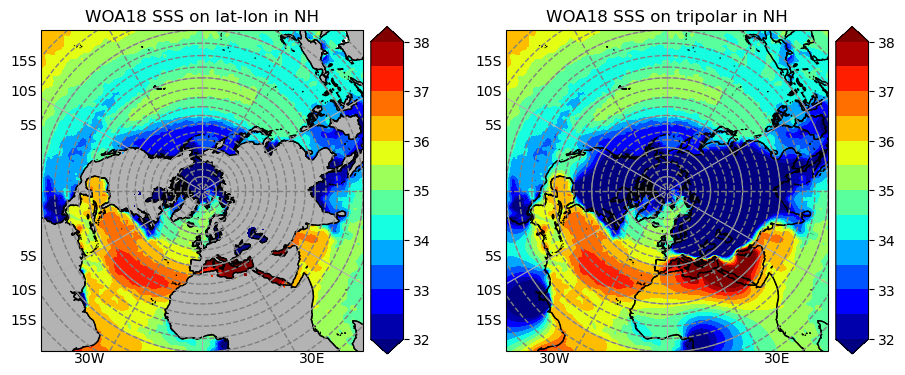

In [8]:
# show WOA SSS in the North Pole

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0)},
                        figsize=(11,8.5))
crs = ccrs.PlateCarree()

for i in [0,1]:
    axs[i].coastlines(linewidth=0.75, color='black', resolution='50m')
    axs[i].gridlines(crs=crs, linestyle='-')
    axs[i].set_extent([-180, 180, 0, 90], crs=crs)
    if i==0:
        surf = axs[i].contourf(lon1d_grd_in, lat1d_grd_in, sss_grd_in, levels=np.arange(32,38.5,0.5), extend="both", cmap=plt.cm.jet, transform=crs)
    else:
        surf = axs[i].contourf(lon2d_grd_out, lat2d_grd_out, remapped_grd_out, levels=np.arange(32,38.5,0.5), extend="both", cmap=plt.cm.jet, transform=crs)

    set_cartopy_colorbar(axs[i],surf,fig,shrink=0.5)

    axs[i].add_feature(cfeature.COASTLINE)
    axs[i].add_feature(cfeature.LAND, facecolor=[0.7,0.7,0.7])
    set_cartopy_gridlines(ax=axs[i],crs=crs,ytick=np.arange(-90,90+10,5))
    
    if i==0:
        axs[i].title.set_text("WOA18 SSS on lat-lon in NH")
    else:
        axs[i].title.set_text("WOA18 SSS on tripolar in NH")    




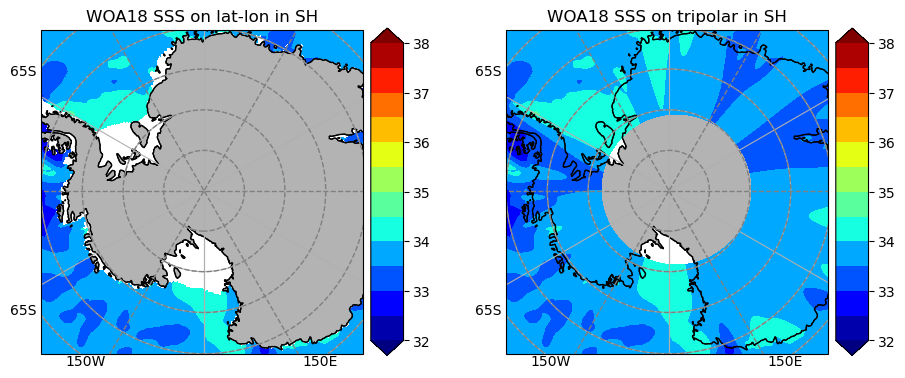

In [9]:
# show WOA SSS in the South Pole

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)},
                        figsize=(11,8.5))
crs = ccrs.PlateCarree()

for i in [0,1]:
    axs[i].coastlines(linewidth=0.75, color='black', resolution='50m')
    axs[i].gridlines(crs=crs, linestyle='-')
    axs[i].set_extent([-180, 180, -90, -70], crs=crs)
    if i==0:
        surf = axs[i].contourf(lon2d_grd_in, lat2d_grd_in, sss_grd_in, levels=np.arange(32,38.5,0.5), extend="both", cmap=plt.cm.jet, transform=crs)
    else:
        surf = axs[i].contourf(lon2d_grd_out, lat2d_grd_out, remapped_grd_out, levels=np.arange(32,38.5,0.5), extend="both", cmap=plt.cm.jet, transform=crs)

    set_cartopy_colorbar(axs[i],surf,fig,shrink=0.5)

    axs[i].add_feature(cfeature.COASTLINE)
    axs[i].add_feature(cfeature.LAND, facecolor=[0.7,0.7,0.7])
    set_cartopy_gridlines(ax=axs[i],crs=crs,ytick=np.arange(-90,90+10,5))
    
    if i==0:
        axs[i].title.set_text("WOA18 SSS on lat-lon in SH")
    else:
        axs[i].title.set_text("WOA18 SSS on tripolar in SH")    





In [14]:
# fill values where mask is ocean
# remapped_grd_out: on tripolar grid
# sss_grd_out: 12*1080*1440

fn_grd_out = 'nudging_utils/flood_salt_restore_PHC2.1440x1080.v20180405.nc'
f = Dataset(fn_grd_out)
lat2d_grd_out = f.variables['lat'][:]
lon2d_grd_out = f.variables['lon'][:]
sss_grd_out   = f.variables['SALT'][:]
f.close()

sss_1month = np.squeeze(sss_grd_out[0,:,:].copy())
print("sss_1month BEFORE remapping: min, max",sss_1month.shape, np.min(sss_1month),np.max(sss_1month))
ocn_pts = wet_grd_out>0.1 
sss_1month[ocn_pts] = remapped_grd_out[ocn_pts]
print("sss_1month AFTER remapping: min, max",np.min(sss_1month),np.max(sss_1month))

#n_missing_pts = np.sum(np.isnan(remapped_grd_out) & (wet_grd_out>0.1))
n_missing_pts = np.sum( (remapped_grd_out>50) )
print("n_missing_pts=",n_missing_pts, "percent(%)=", n_missing_pts*100.0/(1080*1440))

sss_1month BEFORE remapping: min, max (1080, 1440) 3.7571 40.4879
sss_1month AFTER remapping: min, max 3.770253 40.859764
n_missing_pts= 0 percent(%)= 0.0


<class 'numpy.ma.core.MaskedArray'> <class 'numpy.ma.core.MaskedArray'>
n_missing= (0,)


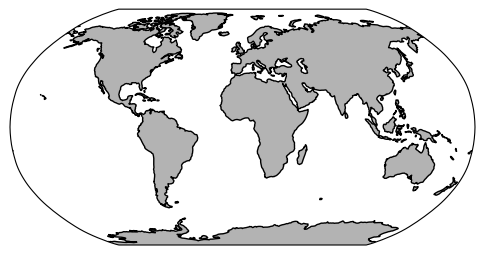

In [15]:
print(type(sss_1month), type(wet_grd_out))

lat_missing_pts = lat2d_grd_out[np.isnan(sss_1month) & (wet_grd_out>0.1)]
lon_missing_pts = lon2d_grd_out[np.isnan(sss_1month) & (wet_grd_out>0.1)]

print("n_missing=",lat_missing_pts.shape)


fig2  = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot(111,projection=ccrs.Robinson())
crs=ccrs.PlateCarree()

#surf2 = ax2.contourf(lon2d_grd_in, lat2d_grd_in, sss_grd_in, levels=np.arange(32,38.5,0.5), extend="both", cmap=plt.cm.jet, transform=crs)

ax2.scatter(x=lon_missing_pts, y=lat_missing_pts,
            color="red",
            s=1,
            alpha=0.5,
            transform=crs) ## Important


ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.LAND, facecolor=[0.7,0.7,0.7])




